In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime

from bs4 import BeautifulSoup
from lxml import etree
# from parsel import Selector
import requests
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from time import sleep

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

/Users/CUop/opt/anaconda3/envs/jupy/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
from utils.scraping_utils import get_proxy_list
from random import choice
PROXY_SERVER_LIST = get_proxy_list(only_https=True)

In [17]:
CHROME_PATH = "/opt/homebrew/bin/chromedriver"
HEADERS = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36",
    }
PARAMS = {}

def scrape_fund_page(url, use_proxy)->list:
    MAX_ATTEMPT = 3
    for attempt in range(MAX_ATTEMPT):
        try:
            if use_proxy:
                proxy_server = choice(PROXY_SERVER_LIST)
                proxies = {"http": proxy_server, "https": proxy_server}
                html = requests.get(url, headers=HEADERS, proxies=proxies, timeout=10)
                print(f"Using proxy server {proxy_server}") 
            else:
                html = requests.get(url, headers=HEADERS, timeout=10)
        except:
            print(f"Request failed on {url} Retry {attempt + 1}")
        else:
            break
    else:
        print(f"Request failed on {url} Return None")
        return None
    
    soup = BeautifulSoup(html.text, "html.parser")
    dom = etree.HTML(str(soup))
    # selector = Selector(text=html.text)
    
    try:
        fund_goal_amount = soup.select_one("div.wd-ui-campaign-content > div > div:nth-child(7) > div > p:nth-child(1) > span:nth-child(2)").get_text()
        # fund_period = soup.select_one("div.wd-ui-campaign-content > div > div:nth-child(7) > div > p:nth-child(1) > span:nth-child(5)").get_text() # not working
        fund_period = ""
        total_funder = soup.find("p", "total-supporter").text.replace("명의 서포터", "")
    except:
        print(f"Element select failed on {url}. Skip.")
        return None
    
    return [fund_goal_amount, fund_period, total_funder]

def scrape_wadiz_inside(start: int, end: int, use_proxy, backup)->pd.DataFrame:
    assert start <= end, "Invalid range: not start <= end"
    
    df_wadiz_list = pd.read_csv("./data/wadiz_list.csv", index_col=0)[start:end]
    COLUMNS = ["FundGoalAmount", "FundPeriod", "TotalFunder"]
    df_wadiz_list[COLUMNS] = None

    for i in tqdm(range(start, end)):
        url = df_wadiz_list.loc[i, "Link"]
        ls = scrape_fund_page(url, use_proxy=use_proxy)
        if not ls:
            continue
        
        for col, value in zip(COLUMNS, ls):
            df_wadiz_list.loc[i, col] = value
    
    if backup:
        df_wadiz_list.to_csv(f"./data/backups/wadiz_list_{start}_{end}.csv")

    return df_wadiz_list

def multi_init(use_proxy=False, backup=False)->pd.DataFrame:
    df_wadiz_list = pd.read_csv("./data/wadiz_list.csv", index_col=0)
    work_list = [(i, min(i + 500, len(df_wadiz_list))) for i in range(0, len(df_wadiz_list), 500)]
    # work_list = [(0, 7), (500, 503)]
    print(work_list)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(scrape_wadiz_inside, work[0], work[1], use_proxy, backup) for work in work_list]

        df_result = pd.DataFrame()
        for future in as_completed(futures):
            result = future.result()
            df_result = pd.concat([df_result, result])
        
    return df_result

In [18]:
df = multi_init(backup=True)
df.to_csv("./data/wadiz_list_full.csv", encoding="utf-8-sig")
df.head()

[(0, 500), (500, 1000), (1000, 1500), (1500, 2000), (2000, 2500), (2500, 3000), (3000, 3500), (3500, 4000), (4000, 4500), (4500, 5000), (5000, 5500), (5500, 6000), (6000, 6500), (6500, 7000), (7000, 7500), (7500, 8000), (8000, 8500), (8500, 9000), (9000, 9500), (9500, 9984)]


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

,Title,Category,Maker,FundPercentage,FundAmount,RemainingDay,Link,FundGoalAmount,FundPeriod,TotalFunder
0,"[모공케어1위]모공볼륨개선 최대61.7% 단,2주만에 모공다이어트 성공",뷰티,주식회사 에스스킨,2111%,"10,556,010원",오늘마감,https://www.wadiz.kr/web/campaign/detail/14808...,"500,000원",,199
1,[홈바&홈술 필수템]카빙 없이 쉽게 즐기세요! 녹지 않는 얼음 쥬얼아이스,홈·리빙,(주)마스터마인딩그룹,17174%,"85,873,000원",30일,https://www.wadiz.kr/web/campaign/detail/15022...,"500,000원",,"1,545"
2,40년 스텐 제조사의 스텐 캠핑 반합ㅣ라면 3개도 거뜬하게 끓여요,여행·레저,(주)영인정공,2227%,"11,135,900원",7일,https://www.wadiz.kr/web/campaign/detail/15267...,"500,000원",,360
3,"[국내단독공개]보석감정사가 엄선한 세계 4대 귀보석, 물방울화이트사파이어",패션·잡화,더켈리,4666%,"23,332,000원",7일,https://www.wadiz.kr/web/campaign/detail/12899...,"500,000원",,84
4,[1억 초코볼 마지막앵콜]커뮤니티에서 완전 난리난 초콜릿 꼭 드셔보셔요!,푸드,주식회사 온유어사이드,3086%,"15,430,000원",14일,https://www.wadiz.kr/web/campaign/detail/15256...,"500,000원",,433


# 출판의 펀딩 달성률 평균이 높은 이유는?

목표 금액 = 펀딩 금액 / (펀딩 달성률 / 100) 으로 구할 수 있었지만, 모른채로 수집했다...

In [19]:
import plotly.graph_objects as go
import plotly.express as px

In [86]:
wadiz_list = pd.read_csv("./data/wadiz_list_full.csv", index_col=0)
wadiz_list = wadiz_list[wadiz_list["RemainingDay"] == "종료"]
wadiz_list["FundPercentage"] = wadiz_list["FundPercentage"].apply(lambda x: int(x.replace("%", ""))) # % 제거
wadiz_list["FundAmount"] = wadiz_list["FundAmount"].apply(lambda x: x.replace("원", "")) # 원 제거
wadiz_list["FundAmount"] = wadiz_list["FundAmount"].apply(lambda x: int(x.replace(",", ""))) # , 제거
wadiz_list["FundGoalAmount"] = wadiz_list["FundGoalAmount"].apply(lambda x: x.replace("원", "")) # 원 제거
wadiz_list["FundGoalAmount"] = wadiz_list["FundGoalAmount"].apply(lambda x: int(x.replace(",", ""))) # , 제거
wadiz_list["TotalFunder"] = wadiz_list["TotalFunder"].apply(lambda x: int(x.replace(",", "")))
wadiz_list["AmountPerFunder"] = wadiz_list["FundAmount"] / wadiz_list["TotalFunder"]
wadiz_list.drop("FundPeriod", 1, inplace = True)


wadiz_list_group = wadiz_list.groupby(by=["Category"]).mean().sort_values(by=["FundPercentage"], ascending=False)
category_sorter = list(wadiz_list_group.index)
category_sorter_index = dict(zip(category_sorter, range(len(category_sorter))))
wadiz_list_group = wadiz_list_group.reset_index()

# 그룹 순서에 맞게 정렬
wadiz_list["CategoryRank"] = wadiz_list["Category"].map(category_sorter_index)
wadiz_list.sort_values(["CategoryRank"], ascending=True, inplace=True)
wadiz_list.drop("CategoryRank", 1, inplace = True)

# 막대 차트 시각화
fig1 = px.bar(wadiz_list_group, x="Category", y="FundGoalAmount", color="Category")
fig1.update_layout(showlegend=False, yaxis_title="펀딩 목표 금액 (원)")
fig1.show()

# 버블 차트 시각화
# fig2 = px.scatter(wadiz_list[wadiz_list["Category"] == "출판"], x="FundGoalAmount", y="FundPercentage", size="TotalFunder", color="Category", hover_name="Category")
# fig2.show()


/var/folders/fy/vfsf24gn1c78_7xkw_jwnkc00000gq/T/ipykernel_42828/1754100917.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/fy/vfsf24gn1c78_7xkw_jwnkc00000gq/T/ipykernel_42828/1754100917.py:21: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



* 출판 분야 펀딩 프로젝트의 목표 금액은 평균 100만원 으로 ~해서 낮은 편이다.
    * 하지만, 출판 분야보다 평균 목표 금액이 낮지만 펀딩 달성률 또한 낮은 분야들이 있다.
    -> 분포 차트


In [ ]:
fig2 = px.scatter(wadiz_list, x="FundGoalAmount", y="FundPercentage",
    color="Category")
fig2.show()

wadiz_list.corr()

,FundPercentage,FundAmount,FundGoalAmount,TotalFunder,AmountPerFunder
FundPercentage,1.000000,0.532706,-0.040041,0.528843,0.099670
FundAmount,0.532706,1.000000,0.558385,0.610641,0.245667
FundGoalAmount,-0.040041,0.558385,1.000000,0.270188,0.185715
TotalFunder,0.528843,0.610641,0.270188,1.000000,-0.143215
AmountPerFunder,0.099670,0.245667,0.185715,-0.143215,1.000000


펀딩 목표 금액 ~ 펀딩 달성률 상관간계 없음

<AxesSubplot:>

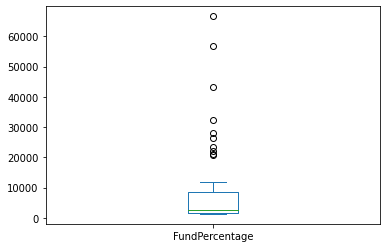

In [122]:
wadiz_list.loc[wadiz_list["Category"] == "출판", 'FundPercentage'].plot(kind='box')

In [89]:
wadiz_list[wadiz_list["Category"] == "출판"].describe()

,FundPercentage,FundAmount,FundGoalAmount,TotalFunder,AmountPerFunder
count,55.000000,5.500000e+01,5.500000e+01,55.000000,55.000000
mean,8917.254545,6.193406e+07,1.012727e+06,795.036364,74571.302295
std,13910.514621,8.526203e+07,1.466168e+06,733.715026,61910.327998
min,1283.000000,6.419001e+06,5.000000e+05,67.000000,9261.422638
25%,1731.500000,1.177650e+07,5.000000e+05,241.500000,33997.868713
50%,2583.000000,2.324190e+07,5.000000e+05,574.000000,56874.885845
75%,8579.000000,5.938790e+07,1.000000e+06,985.500000,99537.677643
max,66619.000000,3.330980e+08,1.000000e+07,3006.000000,338522.455090


출판 펀딩 달성률은 평균 8917, 표준편차 13910로 표준편차가 매우 큰 편

In [102]:
fig = px.pie(
    wadiz_list[wadiz_list["Category"] == "출판"],
    values="FundAmount",
    names="Maker",
    title="출판 프로젝트별 펀딩 금액"
)
fig.update_layout(showlegend=False)
fig.update_traces(textposition="inside")
fig.show()

In [105]:
fig = px.bar(wadiz_list_group, x="Category", y="TotalFunder", color="Category", title="펀딩 참여자 수 평균")
fig.update_layout(showlegend=False)
fig.show()

출판은 펀딩 리스크가 적어서 참여자가 많을 것이다? -> 출판의 펀딩 참여자 수가 특출나게 많지는 않다.

왜 출판의 펀딩 달성률이 높은지 잘 모르겠다... <- 왜 알아야 하지?

# 1인당 펀딩 금액이 높은 분야는?

In [71]:
fig3 = px.bar(wadiz_list_group, x="Category", y="AmountPerFunder", color="Category", title="1인당 펀딩 금액")
fig3.update_layout(showlegend=False, yaxis_title="펀딩 금액 (원)")
fig3.show()

* 펀딩 최소 비용이 높아서 1인당 펀딩 금액이 높은 걸까, 다른 이유로 높은 걸까?

# 분야 별 펀딩 프로젝트 수

In [119]:
wadiz_list

,Title,Category,Maker,FundPercentage,FundAmount,RemainingDay,Link,FundGoalAmount,TotalFunder,AmountPerFunder,Count
5856,"불황에도 웃습니다, 투자왕 김단테의 ""절대수익 투자법칙""",출판,픗픗아카데미,2430,24303661,종료,https://www.wadiz.kr/web/campaign/detail/68107...,1000000,688,35325.088663,1
1592,[직장인 투잡] 하루 1시간 수익 파이프라인 만들기 - 티스토리 블로그,출판,코딩팩토리,9011,45059000,종료,https://www.wadiz.kr/web/campaign/detail/13407...,500000,895,50345.251397,1
7453,"""읽는 내내 소름끼친다"" 역사의 주인공들이 생생히 전하는 ""역사의 원전""",출판,(주)바다출판사,1871,18716000,종료,https://www.wadiz.kr/web/campaign/detail/11612...,1000000,620,30187.096774,1
1420,"[하루 1시간] 왜 안해? 현실적인 제 2월급, 티스토리 구글애드센스",출판,송진영,10258,51290960,종료,https://www.wadiz.kr/web/campaign/detail/13387...,500000,468,109596.068376,1
798,[5억 레전드부업] 10페이지 PDF 전자책으로 5억 번 비법서,출판,유성우(바이컴퍼니),22068,110343850,종료,https://www.wadiz.kr/web/campaign/detail/14856...,500000,1024,107757.666016,1
...,...,...,...,...,...,...,...,...,...,...,...
1299,"[3.3억/만족도5점] 자영업자 1,000억 비즈니스 만들기 프로젝트",클래스·컨설팅,중간계캠퍼스,11113,111130000,종료,https://www.wadiz.kr/web/campaign/detail/14419...,1000000,212,524198.113208,1
7550,[신년 파격 혜택] 나만 시작 안했쥐? 데이터 분석으로 연봉 올려보소~!,클래스·컨설팅,머니매그넷 주식회사(마소캠퍼스),1842,18424000,종료,https://www.wadiz.kr/web/campaign/detail/10024...,1000000,105,175466.666667,1
8150,"""25년 경력, 스페인어 레전드"" 실비아쌤과 <스페인어 무조건 말하기>",클래스·컨설팅,실비아스페인어,1658,8290000,종료,https://www.wadiz.kr/web/campaign/detail/13260...,500000,44,188409.090909,1
2701,"포토샵 온라인 클래스, 하루 10분으로 연봉 2배! 조회수 2배!",클래스·컨설팅,베어유,5313,53134510,종료,https://www.wadiz.kr/web/campaign/detail/55383...,1000000,856,62073.025701,1


In [109]:
wadiz_list["Count"] = 1
df = wadiz_list.groupby(by=["Category"]).sum().reindex(category_sorter).reset_index()
dict_wadiz_count = dict(zip(df["Category"], df["Count"]))

fig4 = px.bar(df, x="Category", y="Count", color="Category", title="펀딩 프로젝트 수")
fig4.update_layout(showlegend=False, yaxis_title="펀딩 금액 (원)")
fig4.show()

* 펀딩 프로젝트 수 vs 금액 관련 지수 둘 중 무엇이 더 소비자 수요를 잘 나타낼까?
    * 수요가 많으면 공급이 많다? 고급 기술이 필요하지 않아 진입장벽이 낮은 분야라서 공급이 많을 수도.
    * 

### 펀딩 프로젝트 수가 낮고, 펀딩 달성률/펀딩 금액이 높은 분야가 블루 오션?

In [116]:
df = wadiz_list_group
df["Count"] = df["Category"].map(dict_wadiz_count)

fig = px.scatter_3d(df, x="FundPercentage", y="FundAmount", z="Count", color="Category")
fig.show()

df["Point"] = df["FundAmount"] * df["FundPercentage"] / df["Count"]
df[["Category", "Point"]].sort_values(by=["Point"], ascending=False)

,Category,Point
10,소셜·캠페인,1.161483e+10
0,출판,1.004149e+10
5,캐릭터·굿즈,6.714981e+09
4,베이비·키즈,3.683796e+09
7,게임·취미,2.463333e+09
11,컬쳐·아티스트,2.449223e+09
3,여행·레저,1.308113e+09
14,클래스·컨설팅,9.437955e+08
6,스포츠·모빌리티,6.596592e+08
1,테크·가전,3.545974e+08


* 소셜/캠페인, 출판 분야가 블루 오션이다.
    * 점수 = 펀딩 달성률 * 펀딩 금액 / 프로젝트 수 계산은 타당한가?


fig2 = px.scatter(wadiz_list, x="FundGoalAmount", y="FundPercentage",
    color="Category")
fig2.show()

wadiz_list.corr()

In [ ]:
# 크라우디 조사? -> 크라우디는 카테고리 라벨링이 없다.